##### 3_compileNysSPARCSAndHospitalFeatures


In [1]:
import os
import urllib.request
import pandas as pd
import numpy as np

import geopandas as gpd
import shapely
import pysal as ps
import seaborn as sns
import sklearn.preprocessing as preprocessing

from geopandas.tools import sjoin
from fiona.crs import from_epsg
from pysal.contrib.viz import mapping as maps
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/pysal/contrib/viz/mapping.py:32: UserWarning: Bokeh not installed. Functionality related to it will not work
  warn('Bokeh not installed. Functionality '


In [2]:
dataFol = os.getcwd() + "/dataFiles/"
nysHealth = dataFol + "nysHealth/"

In [3]:
# Hospital Inpatient Discharges (SPARCS De-Identified)
# from https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/gnzp-ekau
# The Statewide Planning and Research Cooperative System (SPARCS) Inpatient De-identified File contains discharge
# level detail on patient characteristics, diagnoses, treatments, services, and charges. This data file contains 
# basic record level detail for the discharge. The de-identified data file does not contain data that is protected 
# health information (PHI) under HIPAA. The health information is not individually identifiable; all data elements 
# considered identifiable have been redacted. For example, the direct identifiers regarding a date have the day and 
# month portion of the date removed.

sparcsUrl = ["https://health.data.ny.gov/api/views/gnzp-ekau/rows.csv?accessType=DOWNLOAD", # sparcs 2016
             "https://health.data.ny.gov/api/views/82xm-y6g8/rows.csv?accessType=DOWNLOAD", # sparcs 2015
             "https://health.data.ny.gov/api/views/rmwa-zns4/rows.csv?accessType=DOWNLOAD", # sparcs 2014
             "https://health.data.ny.gov/api/views/npsr-cm47/rows.csv?accessType=DOWNLOAD"] # sparcs 2013

In [4]:
sparcsFiles = ["sparcs2016.csv", 
               "sparcs2015.csv",
               "sparcs2014.csv",
               "sparcs2013.csv"]

In [5]:
if not os.path.isdir(nysHealth):
    os.system("mkdir " + nysHealth)
else:
    print("you can continue")

you can continue


In [6]:
for sp in range(len(sparcsFiles)):
    ### check that the file is not already there
    if not os.path.isfile(nysHealth + sparcsFiles[sp]):
        if os.path.isfile(sparcsFiles[sp]):
            # if in the current dir just move it
            os.system("mv " + sparcsFiles[sp] + " " + nysHealth)
            print ("Moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(sparcsFiles[sp]):
                urllib.request.urlretrieve(sparcsUrl[sp], sparcsFiles[sp])
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + sparcsFiles[sp] + " " + nysHealth)
    ### One final check:
    if not os.path.isfile(nysHealth + sparcsFiles[sp]):
        print ("WARNING!!! something is wrong: the file is not there!")
    else:
        print ("file in place, you can continue")

file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue


In [7]:
collect_df = {}

for i in range(len(sparcsFiles)):
    df_name = sparcsFiles[i].split(".")[:-1][0]
    temp = pd.read_csv(nysHealth + sparcsFiles[i], low_memory=False)
    temp['yr'] = sparcsFiles[i].split(".")[:-1][0][6:]
    temp.rename(columns={'Facility ID':'Facility Id'}, 
                 inplace=True)
    print(temp.shape)
    collect_df[df_name] = temp

(2343429, 39)
(2346931, 38)
(2367550, 38)
(2428905, 38)


In [8]:
sparcsAll = pd.concat(collect_df, ignore_index=True, keys=None, sort=False)

In [9]:
sparcsAll.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs,yr,Ratio of Total Costs to Total Charges
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,167816.0,167816.0,NaN,0,N,Y,5621.25,5037.17,2013,NaN
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,90301264.0,NaN,NaN,0,N,Y,2998.65,2940.46,2013,NaN
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,M,White,Not Span/Hispanic,...,90301264.0,NaN,NaN,0,N,Y,2037.00,2246.15,2013,NaN
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,50 to 69,147,F,White,Not Span/Hispanic,...,90301264.0,NaN,NaN,0,N,N,2435.75,2271.92,2013,NaN
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,M,White,Not Span/Hispanic,...,90301264.0,167816.0,NaN,0,N,Y,3754.95,3579.69,2013,NaN


In [10]:
shSparcs = sparcsAll[['yr', 'Facility Id', 'Facility Name', 'Health Service Area',
                      'APR DRG Code', 'APR DRG Description', 'Total Charges', 'Total Costs',
                     'Length of Stay', 'Type of Admission', 'APR Severity of Illness Description', 
                     'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3']]
shSparcs.head()

,yr,Facility Id,Facility Name,Health Service Area,APR DRG Code,APR DRG Description,Total Charges,Total Costs,Length of Stay,Type of Admission,APR Severity of Illness Description,Payment Typology 1,Payment Typology 2,Payment Typology 3
0,2013,37.0,Cuba Memorial Hospital Inc,Western NY,139,Other pneumonia,5621.25,5037.17,8,Urgent,Major,Medicare,Private Health Insurance,Federal/State/Local/VA
1,2013,37.0,Cuba Memorial Hospital Inc,Western NY,113,Infections of upper respiratory tract,2998.65,2940.46,3,Elective,Minor,Medicare,NaN,NaN
2,2013,37.0,Cuba Memorial Hospital Inc,Western NY,244,Diverticulitis & diverticulosis,2037.00,2246.15,2,Urgent,Minor,Medicaid,NaN,NaN
3,2013,37.0,Cuba Memorial Hospital Inc,Western NY,139,Other pneumonia,2435.75,2271.92,3,Elective,Moderate,Blue Cross/Blue Shield,Self-Pay,NaN
4,2013,37.0,Cuba Memorial Hospital Inc,Western NY,139,Other pneumonia,3754.95,3579.69,4,Elective,Moderate,Medicare,Private Health Insurance,NaN


##### Descriptive Stats on All Inpatient Discharges

##### By Year

In [11]:
shSparcs.groupby(['yr']).count()[['APR DRG Code']]

,APR DRG Code
yr,
2013,2428905
2014,2367550
2015,2346931
2016,2343429


Appears to be fairly consistent the number of inpatient discharges in New York State between 2013 and 2016.

##### By Year and APR Risk of Mortality

In [12]:
sparcsAll.groupby(['yr', 'APR Risk of Mortality']).count()[['APR DRG Code']].pivot_table(index='APR Risk of Mortality', columns='yr')

APR DRG Code                           
yr                            2013     2014     2015     2016
APR Risk of Mortality                                        
Extreme                     106656   111737   121796   127199
Major                       312562   316461   335240   344937
Minor                      1488581  1436544  1389754  1376924
Moderate                    521063   502759   500030   494302

In [13]:
shSparcs.groupby(['yr', 'APR Severity of Illness Description']).count()[['APR DRG Code']].pivot_table(index='APR Severity of Illness Description', columns='yr')

APR DRG Code                        
yr                                          2013    2014    2015    2016
APR Severity of Illness Description                                     
Extreme                                   129089  135805  146798  151900
Major                                     481616  494599  517086  527932
Minor                                     884614  828931  785636  774579
Moderate                                  933543  908166  897300  888951

In general it seems like there are more inpatient illnesses that are classified as "Minor" or "Moderate" than there are "Extreme" or "Major". This is true both from the 'APR Severity of Illness Description' and the 'APR Risk of Mortality' features.

##### By Year and the Health Service Area

In [14]:
shSparcs.groupby(['yr', 'Health Service Area']).count()[['APR DRG Code']].pivot_table(index='Health Service Area', columns='yr')

APR DRG Code                           
yr                          2013     2014     2015     2016
Health Service Area                                        
Capital/Adiron            164988   164949   167368   170367
Central NY                162781   157237   158342   158588
Finger Lakes              151454   147358   146581   150402
Hudson Valley             252343   244850   245956   248065
Long Island               352658   340905   339325   343072
New York City            1140284  1113931  1092204  1076433
Southern Tier              31236    29983    30201    29560
Western NY                170572   165945   164046   165949

Reviewing the 'Health Service Area' feature, it looks like Long Island and New York City are the areas with the most inpatient discharges. This is probably highly correlated with the population sizes in these respective areas. 

##### By Severity of Illness and the APR DRG Description

In [15]:
shSparcs.groupby(['APR Severity of Illness Description', 'APR DRG Description']).count() \
[['APR DRG Code']].pivot_table(index='APR DRG Description', columns='APR Severity of Illness Description')

APR DRG Code           \
APR Severity of Illness Description                     Extreme    Major   
APR DRG Description                                                        
Abdominal pain                                            212.0   4463.0   
Abortion w/o D&C, aspiration curettage or hyste...         27.0    312.0   
Acute & subacute endocarditis                             573.0    975.0   
Acute anxiety & delirium states                            31.0    863.0   
Acute leukemia                                           2344.0   2832.0   
Acute major eye infections                                 40.0    381.0   
Acute myocardial infarction                              8310.0  22043.0   
Adjustment disorders & neuroses except depressi...          4.0    816.0   
Alcohol & drug dependence w rehab or rehab/deto...         31.0   1654.0   
Alcohol abuse & dependence                               1508.0  11545.0   
Alcoholic liver disease                                  2174.0   7647.0   
Allergic reactions                                        283.0   1318.0   
Amputation of lower limb except toes                     1760.0   5129.0   
Anal procedures                                           121.0    532.0   
Angina pectoris & coronary atherosclerosis                354.0   8417.0   
Appendectomy                                              267.0   1769.0   
Asthma                                                   1278.0   8574.0   
BPD & oth chronic respiratory diseases arising ...        359.0    778.0   
Bacterial & tuberculous infections of nervous s...        485.0    978.0   
Behavioral disorders                                        2.0    631.0   
Bipolar disorders                                         906.0   4444.0   
Bone marrow transplant                                    738.0   1102.0   
Brain contusion/laceration & complicated skull ...        191.0    626.0   
Breast procedures except mastectomy                        21.0    748.0   
Bronchiolitis & RSV pneumonia                             551.0   3617.0   
Burns with skin graft except extensive 3rd degr...        167.0    590.0   
CHEMOTHERAPY                                             1825.0   9217.0   
CVA & precerebral occlusion w infarct                    7805.0  28428.0   
Cardiac arrest and shock                                 1888.0   1224.0   
Cardiac arrhythmia & conduction disorders                3846.0  32364.0   
...                                                         ...      ...   
Sinus & mastoid procedures                                 39.0    149.0   
Skin graft for skin & subcutaneous tissue diagn...        206.0   1325.0   
Skin graft, except hand, for musculoskeletal & ...        126.0    703.0   
Skin ulcers                                               896.0   5932.0   
Spinal disorders & injuries                               182.0    921.0   
Spinal procedures                                         419.0   2259.0   
Splenectomy                                               154.0    274.0   
Syncope & collapse                                        536.0  12531.0   
Tendon, muscle & other soft tissue procedures             451.0   1957.0   
Testes & scrotal procedures                                36.0    128.0   
Thyroid, parathyroid & thyroglossal procedures             71.0    540.0   
Tonsil & adenoid procedures                                49.0    362.0   
Toxic effects of non-medicinal substances                2707.0   5411.0   
Tracheostomy w MV 96+ hours w extensive procedu...      11888.0   1056.0   
Tracheostomy w MV 96+ hours w/o extensive proce...      10380.0   1591.0   
Transient ischemia                                        183.0   4897.0   
Transurethral prostatectomy                                81.0    702.0   
Urethral & transurethral procedures                       399.0   3285.0   
Urinary stones & acquired upper urinary tract o...        255.0   3695.0   
Uterine & adnexa proced

Getting a quick glance at APR Illness and the severity. It seems like it is as expected where cases such as 'Amputation' are mostly major and extreme compare to how 'Vertigo' is mostly minor and moderate. 

##### What are the top 50 APR DRG Descriptions for Inpatient Discharges?

In [16]:
shSparcsByAPR = shSparcs.groupby(['yr', 'APR DRG Code', 'APR DRG Description']).count().pivot_table(index=['APR DRG Code', 'APR DRG Description'], columns='yr')
top50APRDrg = shSparcsByAPR.reindex(shSparcsByAPR['Facility Id'].sort_values(by='2016', ascending=False).index).head(50)['Facility Id']

In [15]:
top50APRDrg

,yr,2013,2014,2015,2016
APR DRG Code,APR DRG Description,,,,
640,"Neonate birthwt >2499g, normal newborn or neonate w other problem",203998,203593,198207,195238
560,Vaginal delivery,147403,149696,146813,142108
720,Septicemia & disseminated infections,74007,84732,95074,93348
540,Cesarean delivery,77872,77008,76088,74558
194,Heart failure,54187,54241,56366,56707
139,Other pneumonia,47076,42210,43009,40890
302,Knee joint replacement,35243,36511,38499,39824
140,Chronic obstructive pulmonary disease,44845,41528,40767,38023
750,Schizophrenia,34279,36090,35651,36329


Getting a sense of what are the top 50 APR codes and their descriptions and the count of the number of discharges per year between 2013 and 2016. 

In [17]:
# list of top 25 APR DRG Codes
top50APRDrgCode = top50APRDrg.reset_index()['APR DRG Code'].values
top50APRDrgCode

array([640, 560, 720, 540, 194, 139, 302, 140, 750, 383, 301, 201, 463,
       460,  45, 753,  53, 751, 175, 775, 141, 249, 420, 221, 254, 403,
       204, 772, 133,  58, 190, 710, 773, 173, 351, 253, 244, 263, 282,
       198, 663, 347, 247, 203, 174, 304, 566, 770, 861, 225])

##### What about the Total Charges?

Text(0.5, 1.0, 'Histogram of Total Charges from 2013 - 2016 for All Inpatient Discharges in New York')

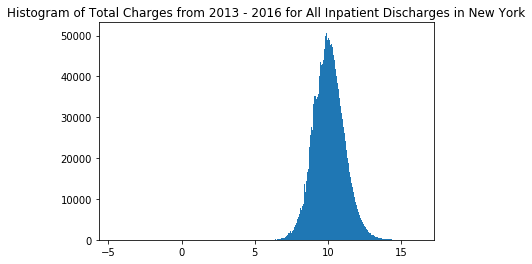

In [18]:
plt.hist(np.log(shSparcs['Total Charges']), bins='auto')
plt.title("Histogram of Total Charges from 2013 - 2016 for All Inpatient Discharges in New York")

Text(0.5, 1.0, 'Histogram of Total Costs from 2013 - 2016 for All Inpatient Discharges in New York')

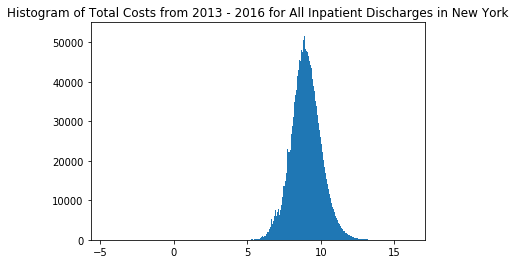

In [19]:
plt.hist(np.log(shSparcs[shSparcs['Total Costs'] > 0]['Total Costs']), bins='auto')
plt.title("Histogram of Total Costs from 2013 - 2016 for All Inpatient Discharges in New York")

Text(0.5, 1.0, 'Histogram of Total Charges from 2013 - 2016 for All Inpatient Discharges in New York from Top 50 APR DRG Codes')

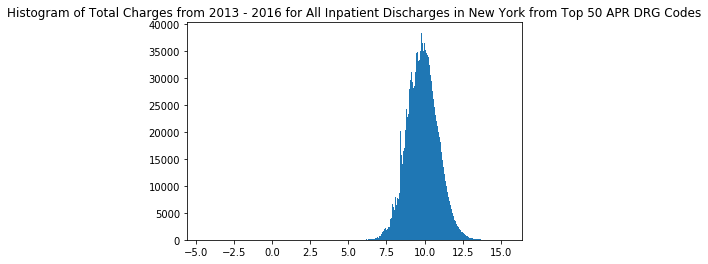

In [20]:
plt.hist(np.log(shSparcs[shSparcs['APR DRG Code'].isin(top50APRDrgCode)]['Total Charges']), bins='auto')
plt.title("Histogram of Total Charges from 2013 - 2016 for All Inpatient Discharges in New York from Top 50 APR DRG Codes")

In [21]:
shSparcs[shSparcs['APR DRG Code'].isin(top50APRDrgCode)]['Total Charges'].describe()

count    6.038763e+06
mean     3.242351e+04
std      4.811788e+04
min      1.000000e-02
25%      9.675930e+03
50%      1.910585e+04
75%      3.721771e+04
max      4.795126e+06
Name: Total Charges, dtype: float64

In [22]:
shSparcs[shSparcs['APR DRG Description'].isin(top50APRDrg.reset_index()['APR DRG Description'].values)]\
.groupby(['yr', 'APR DRG Code', 'APR DRG Description']).mean()[['Total Charges', 'Total Costs']]\
.pivot_table(index=['APR DRG Code', 'APR DRG Description'], columns='yr')

Total Charges  \
yr                                                                        2013   
APR DRG Code APR DRG Description                                                 
45           CVA & precerebral occlusion w infarct                42083.540823   
53           Seizure                                              27091.514157   
58           Other disorders of nervous system                    31366.429139   
133          Respiratory Failure                                  40589.737644   
139          Other pneumonia                                      28253.906186   
140          Chronic obstructive pulmonary disease                26331.386974   
141          Asthma                                               17063.778518   
173          OTHER VASCULAR PROCEDURES                            77423.790341   
174          Percutaneous coronary intervention w AMI             72962.570432   
175          Percutaneous coronary intervention w/o AMI           74204.992547   
190          Acute myocardial infarction                          37447.891911   
194          Heart failure                                        34112.320180   
198          Angina pectoris & coronary atherosclerosis           17024.631211   
201          Cardiac arrhythmia & conduction disorders            23535.790857   
203          Chest pain                                           15268.372028   
204          Syncope & collapse                                   21380.409596   
221          Major small & large bowel procedures                 74153.634493   
225          Appendectomy                                         25256.713974   
244          Diverticulitis & diverticulosis                      24561.415597   
247          Intestinal obstruction                               24797.024826   
249          Other gastroenteritis, nausa & vomiting              18833.959551   
253          Other & unspecified gastrointestinal hemorrhage      33621.614056   
254          Other digestive system diagnoses                     25595.752820   
263          Laparoscopic cholecystectomy                         33857.380641   
282          Disorders of pancreas except malignancy              27378.558964   
301          Hip joint replacement                                55465.507911   
302          Knee joint replacement                               48975.197039   
304          Dorsal & lumbar fusion proc except for curvatur...   94243.739320   
347          Other back & neck disorders, fractures & injuries    28912.684966   
351          Other musculoskeletal system & connective tissu...   25246.577751   
383          Cellulitis & other skin infections                   22674.150896   
403          Procedures for obesity                               32283.587990   
420          Diabetes                                             22513.949450   
460          RENAL FAILURE                                        36226.104591   
463          Kidney & urinary tract infections                    24687.763323   
540          Cesarean delivery                                    22313.868134   
560          Vaginal delivery                                     13145.291818   
566          Other antepartum diagnoses                           16207.876919   
640          Neonate birthwt >2499g, normal newborn or neona...    6434.856896   
663          Other anemia & disorders of blood & blood-formi...   25029.775383   
710          Infectious & parasitic diseases including HIV w...  131826.407045   
720          Septicemia & disseminated infections                 56348.432311   
750          Schizophrenia                                        49170.686209   
751          Major depressive disorders & other/unspecified ...   30349.890185   
753          Bipolar disorders                                    30594.465230   
770          Drug & alcohol abuse or dependence, left agains...    9298.695177   
772          Alcohol & drug dependence w rehab 

##### Get the Hospital Facility and Provider Id Cross Walk
This includes the location - lat and longs

In [23]:
# based on dataset from https://data.medicare.gov/Hospital-Compare/Hospital-General-Information/xubh-q36u
# manual crosswalk from provider id to facility id in googlesheet found here:
# https://docs.google.com/spreadsheets/d/1F8yPe-2uMcAOOzRmYnFenC77GiXnJ0afnRXtBUYe5TQ/edit#gid=1213013033
providerFacIdCrossWalk = pd.read_csv(nysHealth + 'nysHospitalsProviderIdFacilityIdCrossWalk.csv')

In [24]:
providerFacIdCrossWalk.drop(['Unnamed: 0', 'in_nyc', 'Hospital Name',
       'Address', 'City', 'State', 'ZIP Code', 'County Name', 'Phone Number',
       'Hospital Type', 'Hospital Ownership', 'Emergency Services',
       'Meets criteria for meaningful use of EHRs', 
       'Hospital overall rating footnote', 'Mortality national comparison',
       'Mortality national comparison footnote',
       'Safety of care national comparison footnote',
       'Readmission national comparison footnote',
       'Patient experience national comparison footnote',
       'Effectiveness of care national comparison footnote',
       'Timeliness of care national comparison footnote',
       'Efficient use of medical imaging national comparison',
       'Efficient use of medical imaging national comparison footnote'], axis=1, inplace=True)

In [25]:
# extract the lat and long and merge back onto the providerFacIdCrossWalk df
lcnSplit = providerFacIdCrossWalk['Location'].str.split(pat='(', expand=True)[1].str.split(pat=(','), expand=True)
providerFacIdCrossWalk['lat'] = lcnSplit[0]
providerFacIdCrossWalk['long'] = lcnSplit[1].str.split(pat=(')'), expand=True)[0]

In [26]:
providerFacIdCrossWalk.drop(['Location'], axis=1, inplace=True)

In [45]:
providerFacIdCrossWalk.head()

,Provider ID,fac_id,Hospital overall rating,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,lat,long,lonlat,geometry
0,330013,1.0,2,Above the national average,Below the national average,Below the national average,Same as the national average,Below the national average,42.653254,-73.77386,"(-73.77386, 42.653254)",POINT (-73.77386 42.653254)
1,330003,4.0,3,Same as the national average,Above the national average,Below the national average,Same as the national average,Below the national average,42.674685,-73.748861,"(-73.748861, 42.674685)",POINT (-73.74886100000001 42.674685)
2,330057,5.0,3,Below the national average,Above the national average,Below the national average,Same as the national average,Below the national average,42.660176,-73.802382,"(-73.802382, 42.660176)",POINT (-73.80238199999999 42.660176)
3,331301,37.0,Not Available,Not Available,Not Available,Not Available,Not Available,Same as the national average,42.213341,-78.288139,"(-78.288139, 42.213341)",POINT (-78.288139 42.213341)
4,330096,39.0,2,Not Available,Above the national average,Below the national average,Same as the national average,Same as the national average,42.122878,-77.949784,"(-77.949784, 42.122878)",POINT (-77.94978399999999 42.122878)


##### Get the PUMA shape files

In [46]:
# get the New York State Shape Files
# manual download fr. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2016&layergroup=Public+Use+Microdata+Areas
# move into the dataFols directory
# get the hosp puf dictionary
if not os.path.isdir(dataFol + 'tl_2016_36_puma10'):
    os.system('mkdir ' + dataFol + '/tl_2016_36_puma10')
    os.system('unzip -d ' + dataFol + '/tl_2016_36_puma10 ' + dataFol + 'tl_2016_36_puma10.zip')
else:
    print("you can continue")

you can continue


In [47]:
# then read it in with geopandas, reading in the shape file with the function 
pumashp = gpd.GeoDataFrame.from_file(dataFol + '/tl_2016_36_puma10/' + 'tl_2016_36_puma10.shp')

In [48]:
pumashp.head()

,STATEFP10,PUMACE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,36,03803,3603803,NYC-Manhattan Community District 10--Central H...,G6120,S,3703010,241237,+40.8137240,-073.9429990,"POLYGON ((-73.95150599999999 40.812008, -73.95..."
1,36,03707,3603707,NYC-Bronx Community District 5--Morris Heights...,G6120,S,3911380,24513,+40.8528801,-073.9087693,POLYGON ((-73.90980999999999 40.85734799999999...
2,36,03201,3603201,Nassau County (Northwest)--North Hempstead Tow...,G6120,S,99590466,40464509,+40.8170441,-073.6919814,"POLYGON ((-73.628102 40.816038, -73.627775 40...."
3,36,03301,3603301,Suffolk County (Northwest)--Huntington Town (N...,G6120,S,117124211,39091315,+40.8985365,-073.3956826,"POLYGON ((-73.34566099999999 40.935497, -73.32..."
4,36,03303,3603303,Suffolk County (Northwest)--Smithtown Town PUMA,G6120,S,139096977,18843675,+40.8704498,-073.2169705,"POLYGON ((-73.24163799999999 40.915457, -73.23..."


In [49]:
pumashp.shape

(145, 11)

In [50]:
pumashp.crs

# CRS are important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of 
# coordinates in an arbitrary space. A CRS tells Python how those coordinates related to places on the Earth. 
# CRS are referred to using codes called proj4 strings.

{'init': 'epsg:4269'}

In [51]:
# reference from Chris Prince's notebook
# combine lat and lon to one column
providerFacIdCrossWalk['lonlat'] = list(zip(pd.to_numeric(providerFacIdCrossWalk.long), pd.to_numeric(providerFacIdCrossWalk.lat)))

# Create Point Geometry for based on lonlat column
providerFacIdCrossWalk['geometry'] = providerFacIdCrossWalk[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [52]:
providerFacIdCrossWalk.head()

,Provider ID,fac_id,Hospital overall rating,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,lat,long,lonlat,geometry
0,330013,1.0,2,Above the national average,Below the national average,Below the national average,Same as the national average,Below the national average,42.653254,-73.77386,"(-73.77386, 42.653254)",POINT (-73.77386 42.653254)
1,330003,4.0,3,Same as the national average,Above the national average,Below the national average,Same as the national average,Below the national average,42.674685,-73.748861,"(-73.748861, 42.674685)",POINT (-73.74886100000001 42.674685)
2,330057,5.0,3,Below the national average,Above the national average,Below the national average,Same as the national average,Below the national average,42.660176,-73.802382,"(-73.802382, 42.660176)",POINT (-73.80238199999999 42.660176)
3,331301,37.0,Not Available,Not Available,Not Available,Not Available,Not Available,Same as the national average,42.213341,-78.288139,"(-78.288139, 42.213341)",POINT (-78.288139 42.213341)
4,330096,39.0,2,Not Available,Above the national average,Below the national average,Same as the national average,Same as the national average,42.122878,-77.949784,"(-77.949784, 42.122878)",POINT (-77.94978399999999 42.122878)


In [53]:
providersGDF = gpd.GeoDataFrame(providerFacIdCrossWalk) # making it into a geodataframe

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


Text(0.5, 1.0, 'Map of New York State Hospitals')

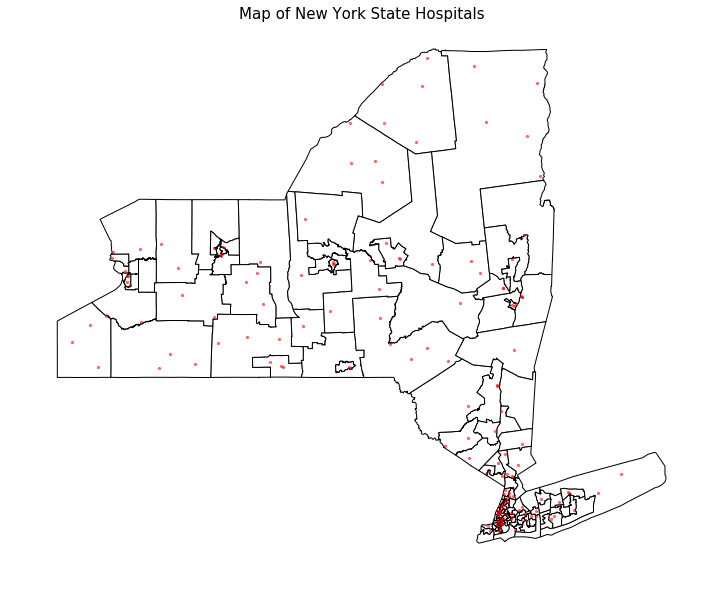

In [62]:
## plotting once using the pylab
# Setup figure and axis
f, ax = plt.subplots(1, figsize = (12,10))
# Plot layer of polygons on the axis
pumashp.plot(ax = ax ,color = 'white',edgecolor = 'black')
providersGDF.plot(ax=ax, column = 'Provider ID', 
                       marker="o", markersize = 5, 
                       color = 'red', alpha = 0.5)

# Remove axis frames
ax.set_axis_off()
# Display
plt.title('Map of New York State Hospitals', fontdict = {'fontsize' : 15})

##### Merge On Hospital Features

In [55]:
# read in the data on hospital features found on CMS
# https://data.cms.gov/Medicare-Inpatient/Medicare-Hospital-Cost-Report-PUF-2014/q74v-7825
hospFeat = pd.read_json("https://data.cms.gov/resource/8rp3-rzmi.json?state_code=NY")
hospFeat.to_csv(dataFol + 'cms/medicareHospitalCostReportPUF2014.csv')

In [56]:
# url for the hosp features dataset (puf) dictionary
pufUrl = 'https://data.cms.gov/api/views/q74v-7825/files/af6d9b58-0f4a-4e0f-815e-ad0ea39ad846?download=true&filename=CostReport_Documentation_2014_Final_Oct_2018.zip'

In [57]:
# get the hosp puf dictionary
if not os.path.isfile(dataFol + 'cms/CostReport_Documentation_2014_Final_Oct 2018.xlsx'):
    urllib.request.urlretrieve(pufUrl, 'CostReport_Documentation_2014_Final_Oct_2018.zip')
    os.system("mv " + "CostReport_Documentation_2014_Final_Oct_2018.zip " + dataFol + 'cms')
    os.system('unzip -d ' + dataFol + 'cms ' + dataFol + '/cms/CostReport_Documentation_2014_Final_Oct_2018.zip')
else:
    print("you can continue")

you can continue


In [58]:
aprHospFeat = shSparcs[(shSparcs['APR DRG Code'].isin(top50APRDrgCode))] \
.merge(providerFacIdCrossWalk, right_on='fac_id', left_on='Facility Id', how='inner')\
.merge(hospFeat, right_on='provider_ccn', left_on='Provider ID', how='inner')

In [ ]:
aprHospFeat.drop(['accounts_payable',
 'accounts_receivable',
 'allowable_dsh_percentage',
 'buildings',
 'cash_on_hand_and_in_banks',
 'city',
 'combined_outpatient_inpatient',
 'contract_labor',
 'cost_of_charity_care',
 'cost_to_charge_ratio',
 'county',
 'deferred_income',
 'depreciation_cost',
 'disproporationate_share',
 'drg_amounts_after_october',
 'drg_amounts_before_october',
 'fiscal_year_begin_date',
 'fiscal_year_end_date',
 'fixed_equipment',
 'fte_employees_on_payroll',
 'general_fund_balance',
 'gross_revenue',
 'health_information_technology',
 'hospital_name',
 'hospital_number_of_beds_for',
 'hospital_total_days_title_1',
 'hospital_total_days_title_2',
 'hospital_total_days_v_xviii',
 'hospital_total_discharges_1',
 'hospital_total_discharges_2',
 'hospital_total_discharges_3',
 'inpatient_revenue',
 'inpatient_total_charges',
 'inventory',
 'investments',
 'land',
 'land_improvements',
 'leasehold_improvements',
 'less_allowances_for',
 'less_contractual_allowance',
 'less_total_operating_expense',
 'major_movable_equipment',
 'managed_care_simulated',
 'medicaid_charges',
 'medicare_cbsa_number',
 'minor_equipment_depreciable',
 'mortgage_payable',
 'net_income',
 'net_income_from_service_to',
 'net_patient_revenue',
 'net_revenue_from_medicaid',
 'net_revenue_from_stand_alone',
 'notes_and_loans_payable_short',
 'notes_payable',
 'notes_receivable',
 'number_of_interns_and',
 'number_of_beds_total_for',
 'other_assets',
 'other_current_assets',
 'other_current_liabilities',
 'other_long_term_liabilities',
 'outlier_payments_for',
 'outpatient_revenue',
 'outpatient_total_charges',
 'overhead_non_salary_costs',
 'payroll_taxes_payable',
 'prepaid_expenses',
 'salaries_wages_and_fees',
 'stand_alone_schip_charges',
 'state_code',
 'street_address',
 'temporary_investments',
 'total_assets',
 'total_bad_debt_expense',
 'total_current_assets',
 'total_current_liabilities',
 'total_days_title_xix',
 'total_days_title_xix_total',
 'total_days_title_xviii',
 'total_days_title_xviii_total',
 'total_days_v_xviii_xix_unknown',
 'total_days_v_xviii_xix_unknown_1',
 'total_discharges_title_xix',
 'total_discharges_title_xix_1',
 'total_discharges_title_xviii',
 'total_discharges_title_xviii_1',
 'total_discharges_v_xviii',
 'total_discharges_v_xviii_1',
 'total_fixed_assets',
 'total_fund_balances',
 'total_ime_payment',
 'total_income',
 'total_liabilities',
 'total_liabilities_and_fund',
 'total_long_term_liabilities',
 'total_other_assets',
 'total_other_expenses',
 'total_other_income',
 'total_salaries_adjusted',
 'total_salaries_from_worksheet',
 'total_unreimbursed_and',
 'unsecured_loans',
 'wage_related_costs_core',
 'wage_related_costs_for_interns',
 'wage_related_costs_for_part',
 'wage_related_costs_rhc_fqhc',
 'zip_code'], axis=1, inplace=True)

In [ ]:
list(aprHospFeat.columns)

In [ ]:
aprHospFeat.describe()

In [ ]:
sns.pairplot(aprHospFeat, hue='Health Service Area', palette="husl")